In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, auc

from sklearn.preprocessing import LabelEncoder

In [7]:
from google.colab import files
!pip install kaggle

In [8]:

!mkdir .kaggle
!touch .kaggle/kaggle.json
!mv .kaggle /root/


#upload kaggle json file

uploaded = files.upload()


mkdir: cannot create directory ‘.kaggle’: File exists
mv: cannot move '.kaggle' to '/root/.kaggle': Directory not empty


Saving kaggle.json to kaggle (1).json


In [9]:
api_token = {"username":"geewynn","key":"b5dd5e9253a91c876fe288606e440250"}

import json
import zipfile

import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')


In [10]:
!kaggle datasets download -d wordsforthewise/lending-club

!unzip '/content/lending-club.zip'

lending-club.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/lending-club.zip
replace accepted_2007_to_2018Q4.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace rejected_2007_to_2018Q4.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [11]:
accepted = pd.read_csv('/content/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
# check the missing value
missing = accepted.isna().mean() *100

#select columns with less than 30% of its data missing
new_df =accepted.loc[:, accepted.isnull().mean() < .30]


#drop all rows with NaN. DUe to the large number of data se have. This will hel reduce computation cost
new_df =new_df.dropna()


#all our columns are uniform
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1652452 entries, 0 to 2260697
Data columns (total 93 columns):
id                            1652452 non-null object
loan_amnt                     1652452 non-null float64
funded_amnt                   1652452 non-null float64
funded_amnt_inv               1652452 non-null float64
term                          1652452 non-null object
int_rate                      1652452 non-null float64
installment                   1652452 non-null float64
grade                         1652452 non-null object
sub_grade                     1652452 non-null object
emp_title                     1652452 non-null object
emp_length                    1652452 non-null object
home_ownership                1652452 non-null object
annual_inc                    1652452 non-null float64
verification_status           1652452 non-null object
issue_d                       1652452 non-null object
loan_status                   1652452 non-null object
pymnt_plan       

In [134]:
new_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,...,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,...,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,...,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.0,0.0,11740.500000,11740.50,10400.0,1340.50,...,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
6,68476668,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,180000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,550xx,MN,14.67,0.0,Jun-1990,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.0,0.0,21393.800000,21393.80,20000.0,1393.80,...,360358.0,94200.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N
7,67275481,20000.0,20000.0,20000.0,36 months,8.49,631.26,B,B1,road driver,10+ years,MORTGAGE,85000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,293xx,SC,17.61,1.0,Feb-1999,705.0,709.0,0.0,8.0,0.0,826.0,5.7,15.0,w,0.0,0.0,21538.508977,21538.51,20000.0,1538.51,...,141601.0,14500.0,4.0,17700.0,13674.0,5.7,0.0,0.0,149.0,55.0,32.0,13.0,3.0,32.0,8.0,1.0,2.0,2.0,3.0,3.0,9.0,3.0,3.0,2.0,8.0,0.0,0.0,1.0,0.0,93.3,0.0,0.0,0.0,193390.0,27937.0,14500.0,36144.0,N,Cash,N


In [135]:
y = new_df['loan_status']


obj_col = new_df.select_dtypes(include='object').columns.values
new_df[obj_col].nunique().sort_values()

debt_settlement_flag          2
initial_list_status           2
disbursement_method           2
application_type              2
pymnt_plan                    2
hardship_flag                 2
term                          2
verification_status           3
home_ownership                6
loan_status                   7
grade                         7
emp_length                   11
purpose                      14
sub_grade                    35
addr_state                   51
issue_d                      77
last_pymnt_d                 79
last_credit_pull_d           81
earliest_cr_line            726
zip_code                    949
title                     31900
emp_title                403738
id                      1652452
url                     1652452
dtype: int64

In [0]:
new_df['emp_length'] = new_df['emp_length'].replace({'< 1 year': 0, 
                                                     '10+ years': 10, 
                                                     '9 years': 9,
                                                     '8 years': 8,
                                                     '7 years': 7,
                                                     '6 years': 6,
                                                     '5 years': 5,
                                                     '4 years': 4,
                                                     '3 years': 3,
                                                     '2 years': 2,
                                                     '1 year': 1}).astype('float')

In [0]:
to_drop = ['id', 'url', 'zip_code', 'loan_status', 'addr_state', 'issue_d', 'emp_title', 'title', 'last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']
new_df = new_df.drop(new_df[to_drop], axis=1)

In [138]:
obj_col = new_df.select_dtypes(include='object').columns
list(obj_col)

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [0]:
col = ['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

le = LabelEncoder()
for cols in col:
  new_df[cols] = le.fit_transform(new_df[cols])

In [140]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1652452 entries, 0 to 2260697
Data columns (total 82 columns):
loan_amnt                     1652452 non-null float64
funded_amnt                   1652452 non-null float64
funded_amnt_inv               1652452 non-null float64
term                          1652452 non-null int64
int_rate                      1652452 non-null float64
installment                   1652452 non-null float64
grade                         1652452 non-null int64
sub_grade                     1652452 non-null int64
emp_length                    1652452 non-null int64
home_ownership                1652452 non-null int64
annual_inc                    1652452 non-null float64
verification_status           1652452 non-null int64
pymnt_plan                    1652452 non-null int64
purpose                       1652452 non-null int64
dti                           1652452 non-null float64
delinq_2yrs                   1652452 non-null float64
fico_range_low         

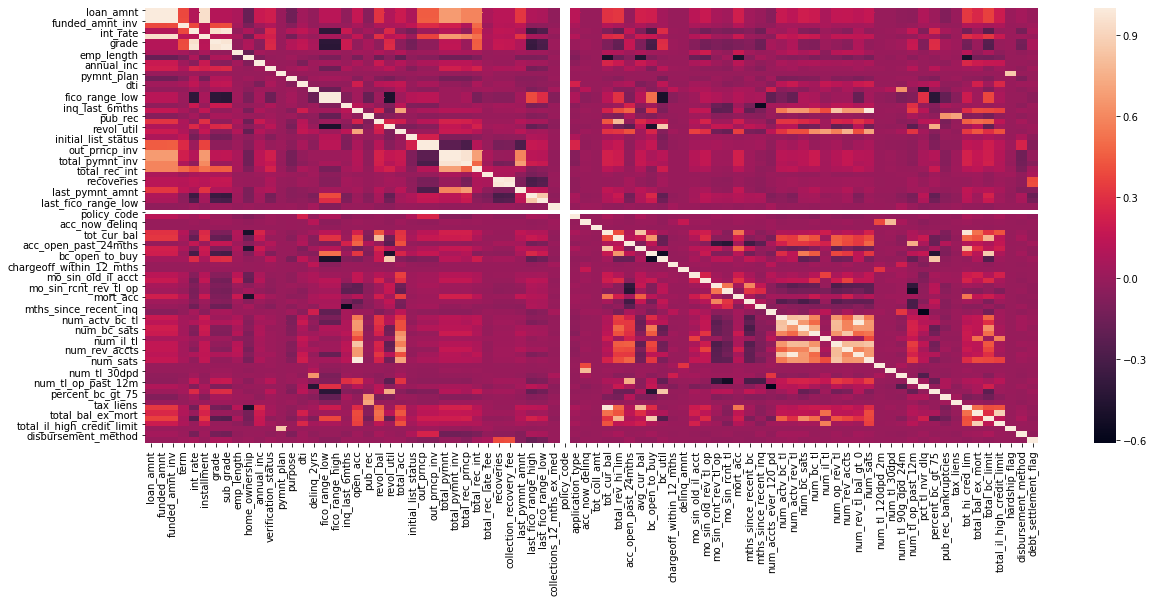

In [141]:
corr = new_df.corr()

plt.figure(figsize=(20,8))
sns.heatmap(corr)

In [0]:
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
high_correlaton = [column for column in upper.columns if any(upper[column] > 0.85)]

In [0]:
#drop highly correlated features

new_df = new_df.drop(new_df[high_correlaton], axis=1)

In [144]:
y.value_counts()

Fully Paid            790625
Current               641230
Charged Off           195388
Late (31-120 days)     15742
In Grace Period         6347
Late (16-30 days)       3092
Default                   28
Name: loan_status, dtype: int64

In [145]:
#y = y.isin(['Default', 'Late (16-30 days)', 'In Grace Period', 'Late (31-120 days)', 'Charged Off']).astype('int')
y = y.isin(['Current', 'Fully Paid']).astype('int')
y.value_counts()

1    1431855
0     220597
Name: loan_status, dtype: int64

In [0]:
X_remain, X_test, y_remain, y_test = train_test_split(new_df, y, stratify=y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, stratify=y_remain, test_size=0.1, random_state=0)

In [147]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [148]:
y_pred = xgb_model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

Accuracy (test): 0.981
Precision (test): 0.980
Recall (test): 0.999


In [149]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     22060
           1       0.98      1.00      0.99    143186

    accuracy                           0.98    165246
   macro avg       0.98      0.93      0.96    165246
weighted avg       0.98      0.98      0.98    165246



In [150]:
y_valid = xgb_model.predict(X_val)

acc_test1 = accuracy_score(y_val, y_valid)
prec_test1 = precision_score(y_val, y_valid)
rec_test1 = recall_score(y_val, y_valid)
print(f'''Accuracy (test): {acc_test1:.3f}
Precision (test): {prec_test1:.3f}
Recall (test): {rec_test1:.3f}
''')

Accuracy (test): 0.981
Precision (test): 0.980
Recall (test): 0.998



In [151]:
print(classification_report(y_val, y_valid))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     19854
           1       0.98      1.00      0.99    128867

    accuracy                           0.98    148721
   macro avg       0.98      0.93      0.96    148721
weighted avg       0.98      0.98      0.98    148721



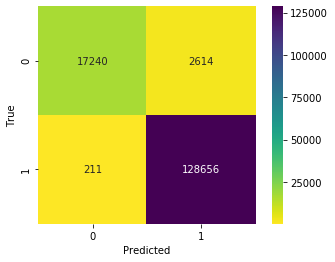

In [152]:
cm_test = confusion_matrix(y_val, y_valid)
ax = sns.heatmap(cm_test, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

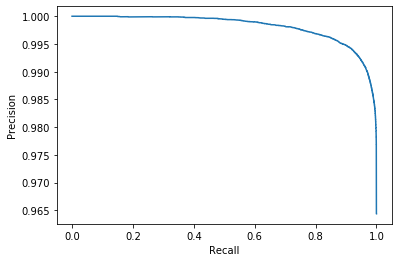

In [153]:
y_proba_val = xgb_model.predict_proba(X_val)[:, 1]
p_val, r_val, t_val = precision_recall_curve(y_val, y_proba_val)
plt.plot(r_val, p_val)
plt.xlabel('Recall')
plt.ylabel('Precision');

In [154]:
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val)
roc_auc = auc(fpr, tpr)
print('The Roc-Auc score is {}'.format(roc_auc))

The Roc-Auc score is 0.9897757464842978


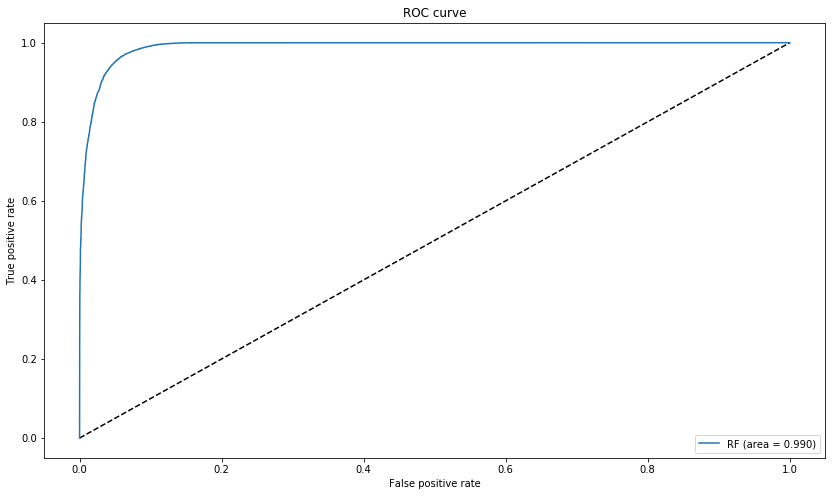

In [155]:
plt.figure(figsize=(14,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)




In [161]:

feature_importances.head(10)

,importance
recoveries,0.523513
last_fico_range_high,0.176010
term,0.103767
last_pymnt_amnt,0.048386
out_prncp,0.032709
loan_amnt,0.029424
total_pymnt,0.027401
total_rec_int,0.019719
total_rec_late_fee,0.011923
debt_settlement_flag,0.010669


In [158]:
prob = xgb_model.predict_proba(X_test)[:,1]
prob

array([0.9910437 , 0.9875545 , 0.97636175, ..., 0.99927694, 0.990271  ,
       0.9890379 ], dtype=float32)

In [171]:
p = pd.DataFrame(prob, columns=['PredProbablity'], index=X_test.index)
p.head()

,PredProbablity
460090,0.991044
1839240,0.987554
2144697,0.976362
707008,0.983741
1259071,0.932922


In [176]:
# pred_data = X_test.merge(p, left_index=True)
# pred_data

X_test['probablty'] = xgb_model.predict_proba(X_test)[:,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,disbursement_method,debt_settlement_flag,probablty
460090,15000.0,0,9.93,5,5,60000.0,1,0,2,24.72,0.0,780.0,1.0,8.0,0.0,1885.0,9.2,20.0,1,10485.46,5810.510000,1295.97,0.0,0.0,483.52,809.0,805.0,0.0,1.0,0,0.0,0.0,47723.0,20500.0,4.0,5965.0,17615.0,0.0,0.0,181.0,196.0,8.0,4.0,1.0,8.0,5.0,0.0,2.0,2.0,4.0,9.0,5.0,6.0,13.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,47723.0,0,0,0.991044
1839240,13500.0,0,18.75,5,5,80000.0,0,0,2,4.89,0.0,670.0,1.0,10.0,0.0,6883.0,70.2,13.0,1,0.00,17772.890326,4272.89,0.0,0.0,492.76,674.0,670.0,0.0,1.0,0,0.0,0.0,6883.0,9800.0,5.0,765.0,913.0,0.0,0.0,69.0,77.0,6.0,6.0,0.0,6.0,1.0,0.0,4.0,8.0,4.0,6.0,1.0,10.0,12.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,6883.0,0,0,0.987554
2144697,35000.0,0,22.91,0,5,42000.0,2,0,2,83.74,2.0,675.0,0.0,13.0,0.0,38413.0,89.1,47.0,0,21397.77,22959.850000,9357.62,0.0,0.0,1353.20,679.0,675.0,0.0,1.0,1,0.0,0.0,100813.0,43100.0,4.0,8401.0,346.0,0.0,0.0,313.0,134.0,10.0,2.0,2.0,60.0,7.0,0.0,2.0,7.0,2.0,6.0,15.0,9.0,30.0,0.0,0.0,0.0,2.0,93.6,100.0,0.0,0.0,100813.0,0,0,0.976362
707008,18000.0,1,13.67,10,5,105000.0,0,0,1,19.84,0.0,695.0,1.0,18.0,0.0,21525.0,41.3,41.0,1,9310.15,14122.170000,5432.32,0.0,0.0,415.76,679.0,675.0,0.0,1.0,0,0.0,0.0,64866.0,52100.0,8.0,3604.0,24530.0,0.0,0.0,151.0,217.0,1.0,1.0,0.0,1.0,2.0,0.0,6.0,7.0,9.0,20.0,15.0,14.0,26.0,0.0,0.0,0.0,6.0,100.0,22.2,0.0,0.0,64866.0,0,0,0.983741
1259071,15200.0,1,22.15,6,5,64000.0,1,0,8,18.86,0.0,675.0,1.0,9.0,0.0,8591.0,87.7,14.0,0,1260.44,24127.890000,10188.33,0.0,0.0,421.11,624.0,620.0,0.0,1.0,0,0.0,77.0,43692.0,9800.0,2.0,4855.0,1209.0,0.0,0.0,130.0,183.0,7.0,7.0,0.0,7.0,3.0,1.0,6.0,6.0,6.0,6.0,7.0,6.0,6.0,0.0,0.0,0.0,1.0,92.9,66.7,0.0,0.0,43692.0,0,0,0.932922


In [184]:
bin = [0, 0.25, 0.500, 0.75, 1]
labels = ['Bad', 'Fair', 'Good', 'Excellent']

X_test['Ratings'] = pd.cut(X_test['probablty'], bins=bin, labels=labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [185]:
X_test.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,disbursement_method,debt_settlement_flag,probablty,Ratings
460090,15000.0,0,9.93,5,5,60000.0,1,0,2,24.72,0.0,780.0,1.0,8.0,0.0,1885.0,9.2,20.0,1,10485.46,5810.510000,1295.97,0.0,0.0,483.52,809.0,805.0,0.0,1.0,0,0.0,0.0,47723.0,20500.0,4.0,5965.0,17615.0,0.0,0.0,181.0,196.0,8.0,4.0,1.0,8.0,5.0,0.0,2.0,2.0,4.0,9.0,5.0,6.0,13.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,47723.0,0,0,0.991044,Excellent
1839240,13500.0,0,18.75,5,5,80000.0,0,0,2,4.89,0.0,670.0,1.0,10.0,0.0,6883.0,70.2,13.0,1,0.00,17772.890326,4272.89,0.0,0.0,492.76,674.0,670.0,0.0,1.0,0,0.0,0.0,6883.0,9800.0,5.0,765.0,913.0,0.0,0.0,69.0,77.0,6.0,6.0,0.0,6.0,1.0,0.0,4.0,8.0,4.0,6.0,1.0,10.0,12.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,6883.0,0,0,0.987554,Excellent
2144697,35000.0,0,22.91,0,5,42000.0,2,0,2,83.74,2.0,675.0,0.0,13.0,0.0,38413.0,89.1,47.0,0,21397.77,22959.850000,9357.62,0.0,0.0,1353.20,679.0,675.0,0.0,1.0,1,0.0,0.0,100813.0,43100.0,4.0,8401.0,346.0,0.0,0.0,313.0,134.0,10.0,2.0,2.0,60.0,7.0,0.0,2.0,7.0,2.0,6.0,15.0,9.0,30.0,0.0,0.0,0.0,2.0,93.6,100.0,0.0,0.0,100813.0,0,0,0.976362,Excellent
707008,18000.0,1,13.67,10,5,105000.0,0,0,1,19.84,0.0,695.0,1.0,18.0,0.0,21525.0,41.3,41.0,1,9310.15,14122.170000,5432.32,0.0,0.0,415.76,679.0,675.0,0.0,1.0,0,0.0,0.0,64866.0,52100.0,8.0,3604.0,24530.0,0.0,0.0,151.0,217.0,1.0,1.0,0.0,1.0,2.0,0.0,6.0,7.0,9.0,20.0,15.0,14.0,26.0,0.0,0.0,0.0,6.0,100.0,22.2,0.0,0.0,64866.0,0,0,0.983741,Excellent
1259071,15200.0,1,22.15,6,5,64000.0,1,0,8,18.86,0.0,675.0,1.0,9.0,0.0,8591.0,87.7,14.0,0,1260.44,24127.890000,10188.33,0.0,0.0,421.11,624.0,620.0,0.0,1.0,0,0.0,77.0,43692.0,9800.0,2.0,4855.0,1209.0,0.0,0.0,130.0,183.0,7.0,7.0,0.0,7.0,3.0,1.0,6.0,6.0,6.0,6.0,7.0,6.0,6.0,0.0,0.0,0.0,1.0,92.9,66.7,0.0,0.0,43692.0,0,0,0.932922,Excellent


In [186]:
X_test['Ratings'].value_counts()

Excellent    142358
Bad           17886
Good           3514
Fair           1488
Name: Ratings, dtype: int64